In [1]:
from scipy.signal import fftconvolve, convolve2d
from astropy.io import fits
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

# settings

In [5]:
simulation = "/scratch/datasets/kat7_hdr/"
neural_output = "/home/gijs/Work/vacuum-cleaner/test/kat7_simulated_hdr/fits/"
number = 1822

# preface

!ls $simulation

In [6]:
psf_path = "{}{}-bigpsf-psf.fits".format(simulation, number)
outputs_path = "{}{}-outputs.fits".format(neural_output, number)
image_path = "{}{}-wsclean-image.fits".format(simulation, number)
skymodel_path = "{}{}-skymodel.fits".format(simulation, number)
dirty_path = "{}{}-wsclean-dirty.fits".format(simulation, number)
model_path = "{}{}-wsclean-model.fits".format(simulation, number)
convolved_path = "{}{}-convoled.fits".format(simulation, number)
residual_path = "{}{}-wsclean-residual.fits".format(simulation, number)

In [7]:
psf = fits.open(psf_path)[0].data.squeeze()
psf = psf / psf.max()
output = fits.open(outputs_path)[0].data.squeeze()    # the output of the neural network
skymodel = fits.open(skymodel_path)[0].data.squeeze() # the skymodel used as input to the telescope sim pipeline
dirty = fits.open(dirty_path)[0].data.squeeze()       # dirty image created by wsclean
image = fits.open(image_path)[0].data.squeeze()       # cleaned image created by wsclean
residual_wsclean = fits.open(residual_path)[0].data.squeeze()       # cleaned image created by wsclean
model_wsclean = fits.open(model_path)[0].data.squeeze()       # cleaned image created by wsclean

In [8]:
threshold = np.mean(output) + np.std(output) * 1
print("threshold: {}".format(threshold))

threshold: 9.127071825787425e-05


# PSF

In [9]:
psf.shape

(512, 512)

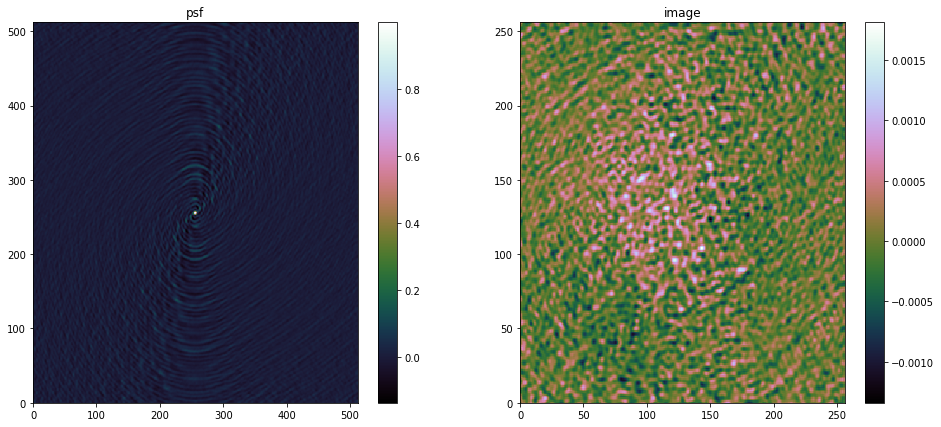

In [10]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(psf, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('psf')
i2 = a2.pcolor(image, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('image')

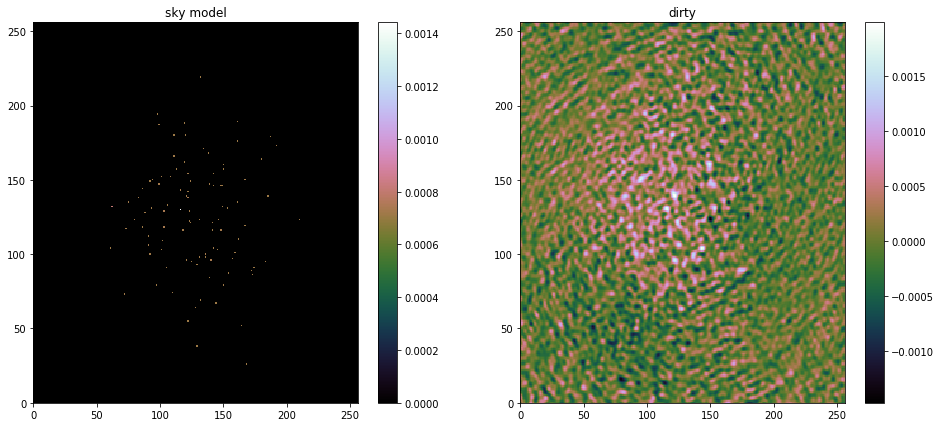

In [11]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('sky model')
i2 = a2.pcolor(dirty, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('dirty')

# thresholding
The scales of the network are still wrong, so we do thresholding and scaling

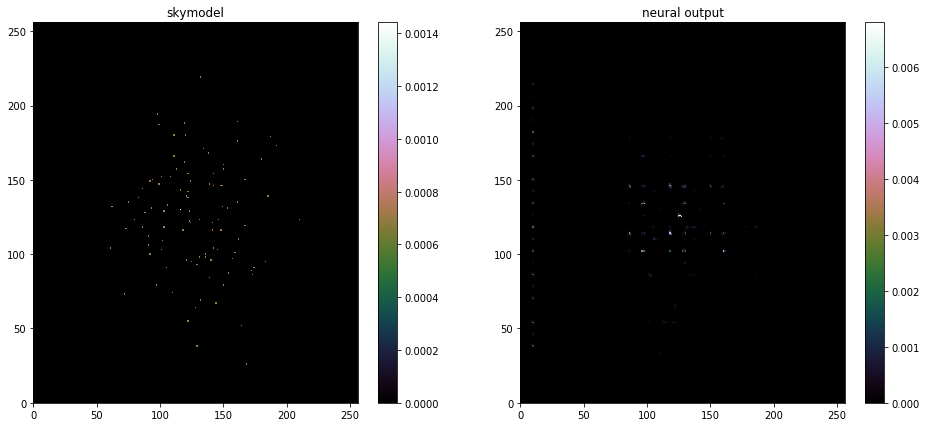

In [12]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('skymodel')
i2 = a2.pcolor(output, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural output')

In [13]:
thresholded = output #* (output > threshold)
# disable scaling for now since we can do that with the dirty image
scaled = thresholded # * (skymodel.max()/thresholded.max())

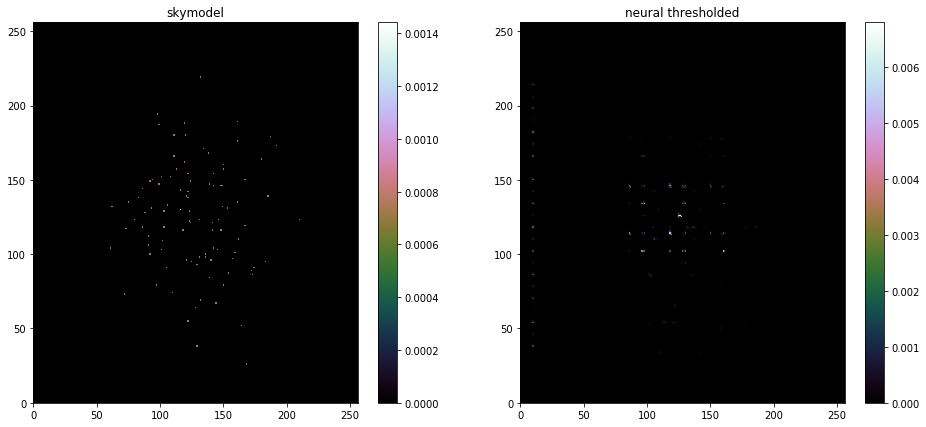

In [15]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('skymodel')
i2 = a2.pcolor(thresholded, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural thresholded')

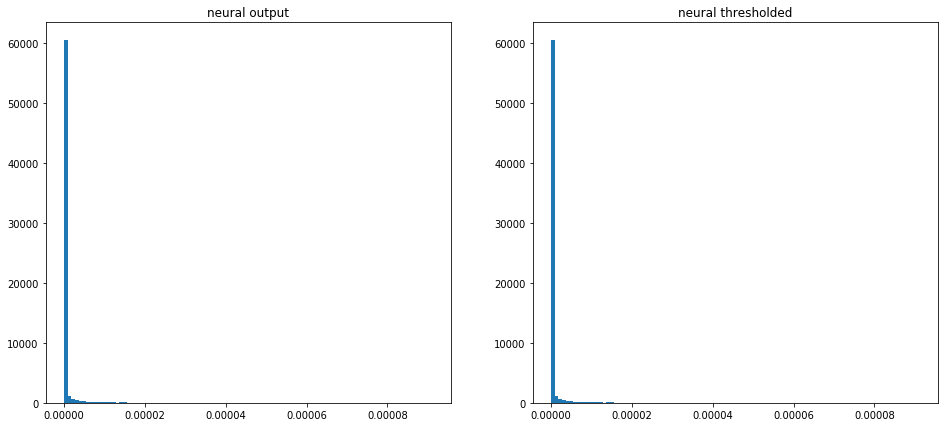

In [16]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
a1.hist(output.flatten(), range=(0, threshold), bins=100)
a1.set_title('neural output')
a2.hist(thresholded.flatten(), range=(0, threshold), bins=100)
_ = a2.set_title('neural thresholded')

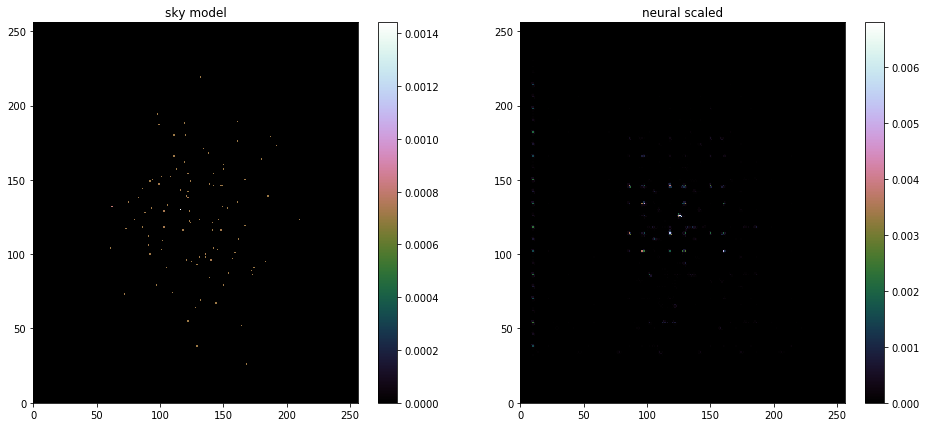

In [17]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('sky model')
i2 = a2.pcolor(scaled, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural scaled')

# Convolving

In [18]:
p = psf.shape[0]
r = slice(p//2, -p//2+1)    # uneven PSF needs +2, even psf +1
convolved2 = fftconvolve(skymodel, psf, mode="full")[r,r]

In [19]:
convolved_skymodel = fftconvolve(skymodel, psf, mode="full")[r,r]
convolved_neural = fftconvolve(scaled, psf, mode="full")[r,r]
convolved_model_wsclean = fftconvolve(model_wsclean, psf, mode="full")[r,r]
convolved_skymodel.shape
#convolved_skymodel = fftconvolve(skymodel, psf, mode="same")
#convolved_neural = fftconvolve(scaled, psf, mode="same")

(256, 256)

In [20]:
convolved_neural.shape

(256, 256)

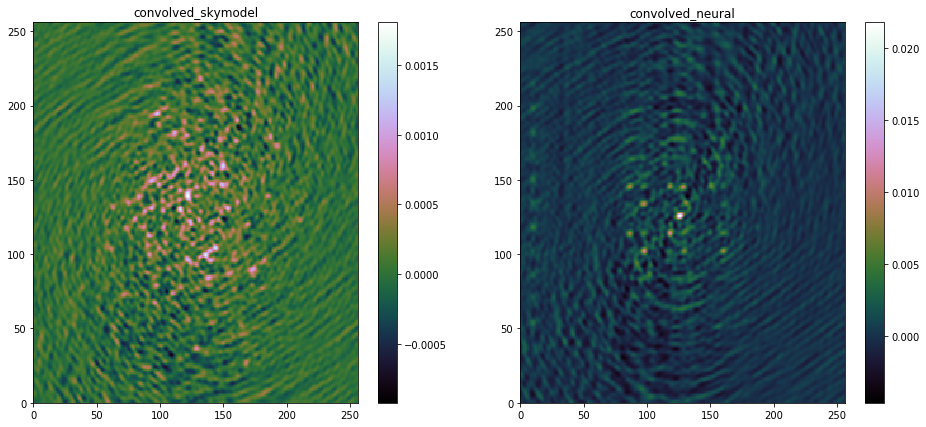

In [21]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(convolved_skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('convolved_skymodel')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

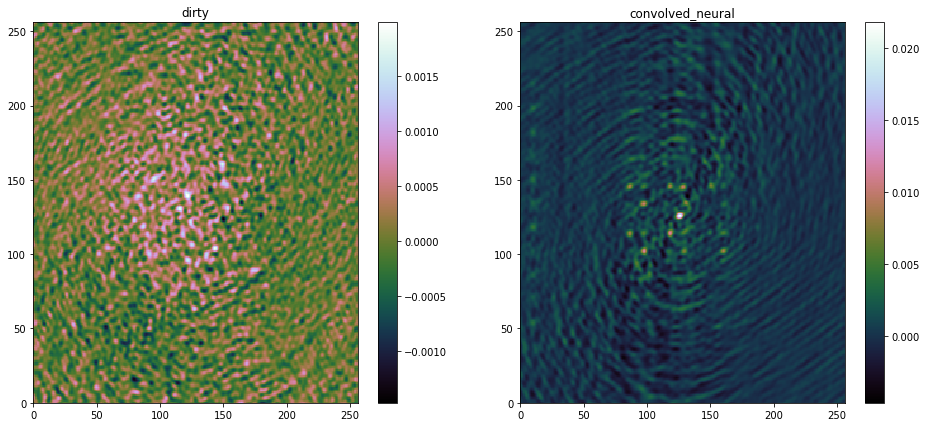

In [22]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(dirty, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('dirty')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

# Risidual

In [23]:
# scale convoled to dirty image
convolved_neural = convolved_neural  #* (dirty.max() / convolved_neural.max())

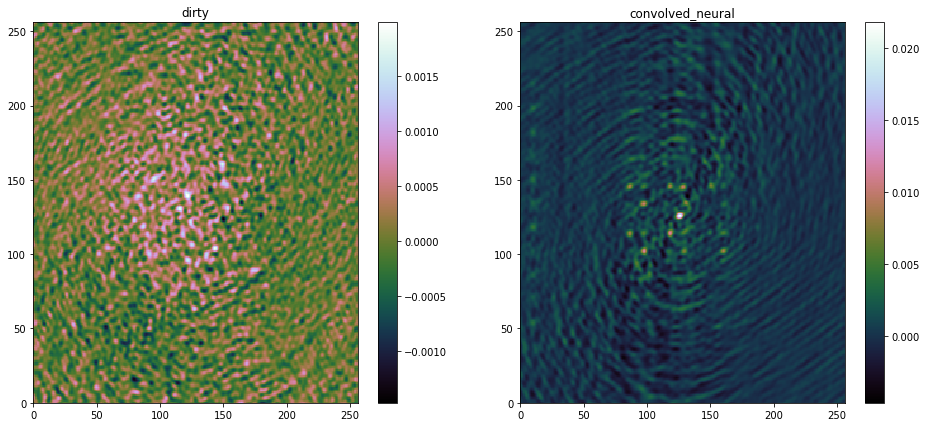

In [24]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(dirty, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('dirty')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

In [25]:
residual_neural = dirty - convolved_neural
residual_skymodel = dirty - convolved_skymodel
residual_model_wsclean = dirty - convolved_model_wsclean

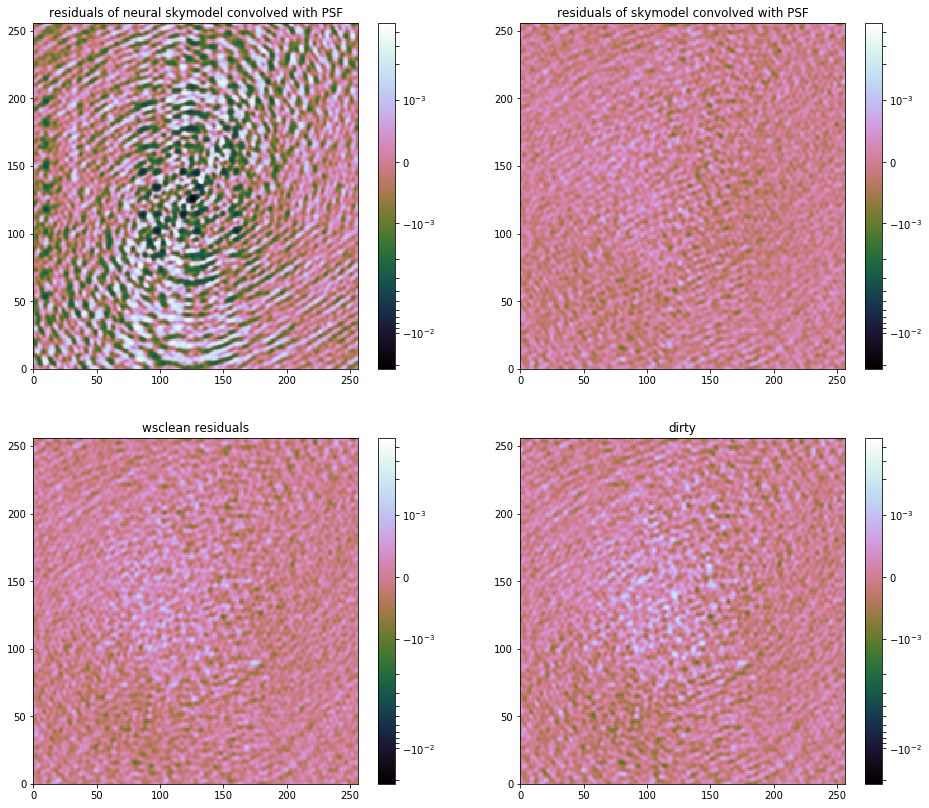

In [26]:
import matplotlib.colors as colors
f, ((a1, a2), (a3, a4))= plt.subplots(2, 2, figsize=(16,14))
vmin, vmax = residual_skymodel.min(), residual_skymodel.max()
norm = colors.SymLogNorm(vmax)
i1 = a1.pcolor(residual_neural, cmap='cubehelix', norm=norm)
a1.set_title('residuals of neural skymodel convolved with PSF')
f.colorbar(i1, ax=a1)
i2 = a2.pcolor(residual_skymodel, cmap='cubehelix', norm=norm)
f.colorbar(i2, ax=a2)
a2.set_title('residuals of skymodel convolved with PSF')
i3 = a3.pcolor(residual_wsclean, cmap='cubehelix',norm=norm)
a3.set_title('wsclean residuals')
f.colorbar(i3, ax=a3)
i4 = a4.pcolor(dirty, cmap='cubehelix', norm=norm)
f.colorbar(i4, ax=a4)
_ = a4.set_title('dirty')

In [30]:
np.std(residual_skymodel)

0.00026195295426825673

In [31]:
np.std(residual_wsclean), np.std(residual_neural)

(0.00029166008, 0.001084634206706864)

In [29]:
# write risidual
hdu = fits.PrimaryHDU(risidual_skymodel)
hdu.header = fits.open(dirty_path)[0].header
hdul = fits.HDUList([hdu])
hdul.writeto(risidual_path, overwrite=True)

NameError: name 'risidual_skymodel' is not defined

In [ ]:
# write convolved
hdu = fits.PrimaryHDU(convolved_skymodel)
hdu.header = fits.open(dirty_path)[0].header
hdul = fits.HDUList([hdu])
hdul.writeto(convolved_path, overwrite=True)